
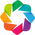

In [77]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import holoviews as hv
import pickle

from progressbar import ProgressBar

import numpy as np

import rnaseq_lib as rna

hv.extension('bokeh')

# t-ETE of Dataset

Use holoviews tabs to separate out coloring to identify subpopulations

    tab 1: color_index = type
    tab 2: color_index = lung (col -> lung_adeno, lung_squamous, not-long, etc)
    ...
    tab n: 

# Inputs

In [3]:
%%time
df_path = '/mnt/rna-seq-analysis/data/xena/deseq2_normalized_tcga_gtex_counts.tsv'
met_path = '/mnt/rna-seq-analysis/metadata/tcga_gtex_metadata_intersect.tsv'
met = pd.read_csv(met_path, index_col=0, sep='\t')
df = pd.read_csv(df_path, index_col=0, sep='\t')

tissues = ['Adrenal', 'Bladder', 'Brain', 'Breast', 'Cervix', 'Colon', 'Small_intestine', 'Esophagus', 'Kidney', 
           'Liver', 'Lung', 'Ovary', 'Pancreas', 'Prostate', 'Skin', 'Head', 'Stomach', 'Testis', 'Thyroid', 'Uterus']

CPU times: user 5min 32s, sys: 9.85 s, total: 5min 42s
Wall time: 5min 42s


In [103]:
met.head(2)

,id,reads,size_MB,platform,sex,tissue,seq_site,weight,height,mapped_reads,race,age,qc,dataset,tumor,type
TCGA-CD-8534-01,TCGA-CD-8534-01,240016440,14982.158203,Illumina HiSeq,male,Stomach,BCGSC,NaN,NaN,207116695.0,asian,40.0,0.0,tcga,yes,Stomach_Adenocarcinoma
TCGA-ER-A19A-06,TCGA-ER-A19A-06,179705496,7383.316781,Illumina HiSeq,male,Skin,UNC,NaN,NaN,178311442.0,white,83.0,4.0,tcga,yes,Skin_Cutaneous_Melanoma


# Create Dataframe for Plotting

Run t-ETE and t-SNE iterating over a range for hyperparameters

In [150]:
%%time
# Collect samples and create base dataframe
plots = {}
samples = [x for x in set(met.index) if x in df.columns]
features = ['id', 'type', 'tumor', 'tissue', 'seq_site', 'dataset', 'sex', 'race', 'age']
plot = met[features].drop_duplicates().loc[samples]

# TSNE
rna.utils.mkdir_p('pandas')
tsne_params = [(30, 200), (50, 200), (30, 500), (50, 500), (50, 750)]
bar = ProgressBar()
for perplexity, learning_rate in bar(tsne_params):
    path = 'pandas/tsne-perplexity_{}-lrate_{}.pandas'.format(perplexity, learning_rate)
    key = '{}-{}'.format(perplexity, learning_rate)
    try:
        plots['tsne'][key] = pd.read_pickle(path)
    except IOError:
        z = rna.dim_red.run_tsne(np.array(df[samples].T), num_dims=2, perplexity=perplexity, learning_rate=learning_rate)
        new = plot.copy()
        new['x'] = z[:, 0]
        new['y'] = z[:, 1]
        new.to_pickle(plots_path)
        plots['tsne'][key] = new
        
# TETE
bar = ProgressBar()
for num_neighbors in bar([10, 30, 50, 70, 100]):
    path = 'pandas/tete-num_neighbors_{}.pandas'.format(num_neighbors)
    try:
        plots['tsne'][num_neighbors] = pd.read_pickle(path)
    except IOError:
        z = rna.dim_red.run_tete(np.array(df[samples].T), num_neighbors=num_neighbors)
        new = plot.copy()
        new['x'] = z[:, 0]
        new['y'] = z[:, 1]
        new.to_pickle(plots_path)
        plots['tsne'][key] = new

NameError: name 'plots_path' is not defined

# Plot of Datset by Num_Neighbors

Convert dataframes to scatter plots

In [45]:
hvs = {}
for k in plots:
    hvs[k] = hv.Scatter(data=plots[k], kdims=['x'], vdims=['y', 'type', 'tumor', 'id'])

Display tete of dataset with varying num_neighbors

In [145]:
%%opts Overlay [tabs=True]
%%opts Scatter [width=1000 height=1000 tools=['hover']]
%%opts Scatter [color_index='tumor' legend_position='left']
%%opts Scatter (cmap='Set1')
plots[50][plots[50]['type'] == 'Adrenal_Gland']
#plots[10].relabel('10') * \
#plots[20].relabel('20') * \
#plots[30].relabel('30') #* \
#plots[40].relabel('40') #* \
#plots[50].relabel('50') #* \
#plots[60].relabel('60') * \
#plots[70].relabel('70') * \
#plots[80].relabel('80') #* \
#plots[90].relabel('90') * \
#plots[100].relabel('100') #* \

:Scatter   [x]   (y,type,tumor,id)

In [44]:
%%opts Scatter [width=500 height=500]
hv.Scatter(data=plots[10], kdims=['x'], vdims=['y', 'type', 'tumor', 'id'])

:Scatter   [x]   (y,type,tumor,id)

In [36]:
tete = hv.Scatter(data=plot, kdims=['x'], vdims=['y', 'type', 'tumor', 'id'])

In [37]:
%%opts Scatter [width=500 height=500]
#%%opts Overlay [tabs=True]
tete

:Scatter   [x]   (y,type,tumor,id)

In [34]:
hv.help(hv.Overlay)

Overlay

Online example: http://holoviews.org/reference/containers/bokeh/Overlay.html

-------------
Style Options
-------------

	alpha, click_policy, color, glyph_height, glyph_width, hover_alpha, hover_color, hover_line_alpha, hover_line_color, label_height, label_standoff, label_width, legend_padding, legend_spacing, line_alpha, line_cap, line_color, line_dash, line_join, line_width, muted_alpha, muted_color, muted_line_alpha, muted_line_color, nonselection_alpha, nonselection_color, nonselection_line_alpha, nonselection_line_color, selection_alpha, selection_color, selection_line_alpha, selection_line_color, text_align, text_alpha, text_baseline, text_color, text_font, text_font_size, text_font_style

(Consult bokeh's documentation for more information.)

------------
Plot Options
------------

The plot options are the parameters of the plotting class:

Parameters of 'OverlayPlot'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan